In [18]:
import pandas as pd
import numpy as np
import numpy.matlib
import math 
from numpy import linalg as LA
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import sklearn.cluster
import sklearn.metrics
import matplotlib.cm as cm
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture
from time import sleep
import sys

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
toy_data = pd.read_csv('/content/drive/My Drive/IS/Final/ToyDataSet.csv').to_numpy()
bboxes = pd.read_csv('/content/drive/My Drive/IS/Final/bboxes.csv')
bboxes_data = bboxes.to_numpy()

In [20]:
bboxes.head()

NameError: name 'bboxes' is not defined

In [21]:
toy_data = pd.read_csv('ToyDataSet.csv').to_numpy()
bboxes_data = pd.read_csv('bboxes.csv').to_numpy()

In [22]:
def normalize(x):
    y = (x - np.mean(x, axis = 0))/np.std(x, axis = 0)
    return y

In [23]:
norm_bboxes = np.zeros((bboxes_data.shape[0],2))
norm_bboxes[ :, 0 ] = (bboxes_data[:,4] - bboxes_data[:,2])/(bboxes_data[:,0])
norm_bboxes[ :, 1 ] = (bboxes_data[:,5] - bboxes_data[:,3])/(bboxes_data[:,1])

In [24]:
toy_data = normalize( toy_data )

In [25]:
np.random.shuffle(toy_data)

### Metric Evaluation

In [26]:
def seperation_index(data, cluster_indices, p = 2):

    def intra_distance(cluster, p = 2): #Calculates maximum intra-cluster distance

        if(p ==2):
            return np.amax(pairwise_distances(cluster, metric = "euclidean"))

        else:
            pairwise = np.zeros((len(cluster), len(cluster)))
            for i in range(len(cluster)):
                for j in range(len(cluster)):
                    pairwise[i][j] = np.linalg.norm(cluster[i] - cluster[j], p)
            print(pairwise)
        return np.amax(pairwise)

    def inter_distance(cluster1, cluster2, p = 2):  #Calculates minimum inter-cluster distance (single-link)
        x = np.zeros((len(cluster1), len(cluster2)))
        x = [[np.linalg.norm(cluster1[i]-cluster2[j], p) for i in range(len(cluster1)) ] for j in range(len(cluster2))]
        return np.amin(x)
    
        
    num_clusters = len(np.unique(cluster_indices))
    cluster_mapping = {} # Dictinary; Partitioning data based on cluster indices

    for i in range(num_clusters):
        cluster_mapping[np.unique(cluster_indices)[i]] = data[np.where(cluster_indices == i)]


    temp = []
    if(num_clusters == 1):
        return 0
    
    for j in range(num_clusters):
        
        inner_temp = []
        for i in range(num_clusters):
            if(i!=j):# Iterating over other clusters after fixing one cluster
                
                # Higher Seperation for Algorithm with further clusters:
                num = inter_distance(data[np.where(cluster_indices ==i)], data[np.where(cluster_indices ==j)], p) 
               
                # Higher Seperation for Algorithm with denser clusters 
                den = np.amax([intra_distance(data[np.where(cluster_indices ==l)], p)  for l in range(num_clusters)]) #
                
                # Normalizing numerators across the whole cluster pairs with the denumerator 
                inner_temp.append(num/den) 
                
    temp.append(min(inner_temp)) 

    seperation_index = min(temp) # Assuming a pessimistic lowerbound along the seperation metric for all pairs

    return seperation_index
        

In [27]:
def fisher_index(data, cluster_indices):
    num_clusters = len(np.unique(cluster_indices))
    data_dimension = len(data[0])
    
    epsilon = (np.amax(data)-np.amin(data))/(10**5) # Preventing Singularity of Sw
    clusters = {} # Dictinary; Partitioning data based on cluster indices

    for i in range(num_clusters):
        clusters[np.unique(cluster_indices)[i]] = data[np.where(cluster_indices == i)]

    if(num_clusters==1):
        return 0
    
    centroids = []
    
    Sw = np.zeros((data_dimension, data_dimension))
    for i in range(len(clusters)):
        Si = np.zeros((data_dimension, data_dimension))
        for q in range(len(clusters[i])):
            
            # Calculating Variance Matrix to obtain Si & Sw
            mul = np.matmul(np.transpose(np.array([clusters[i][q] - np.mean(clusters[i][q])])), np.array([clusters[i][q] - np.mean(clusters[i][q])]))
            Si = np.add(Si, mul)
            
        centroids.append(np.mean(clusters[i], axis = 0)) # Calculating Clusters Centroids
    Sw = np.add(Sw, Si)
    
    
    total_centroid  = np.mean(centroids, axis = 0) # Calculating Between Cluster Covariability using Centroids Covariance Matrix
    Sb = np.zeros((data_dimension, data_dimension))
    
    for i in range(num_clusters):
        Sb = np.add(Sb, np.matmul(np.transpose(np.array([(centroids[i] - (total_centroid))])), np.array([(centroids[i] - (total_centroid))])))
    
    Sw = np.add(Sw, epsilon*np.eye(data_dimension))
    FDI = np.trace(np.matmul(np.linalg.inv(Sw), Sb)) 
    return FDI


In [28]:
def barchart_comparison(algorithms, seperations, fdis, clr = '#ccbfde', title = None): #Gets list of Algorithm Names and Corresponding Seo, Fisher Metrics

    fig, ax = plt.subplots(1, 2, figsize = (20, 7))
    fig.tight_layout(pad = 10.0)

    y_pos = np.arange(len(algorithms))
    ax[0].barh(algorithms, seperations, color = clr)
    ax[0].set_xlabel('Seperation Indices')

    ax[1].barh(algorithms, fdis, color = clr)
    ax[1].set_xlabel('FDI')

    plt.show()

## 2D Histogram of Dataset

Text(0, 0.5, 'Counts')

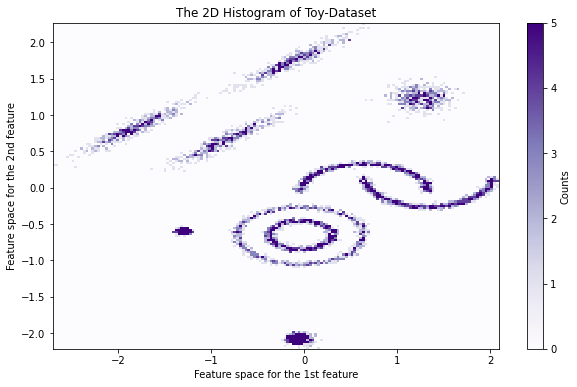

In [29]:
fig2 = plt.figure(figsize=(10, 6))
plt.hist2d(toy_data[ :, 0 ], toy_data[ :, 1 ], bins=160 , cmap = 'Purples' , vmax = 5 )
plt.title("The 2D Histogram of Toy-Dataset")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')

Text(0, 0.5, 'Counts')

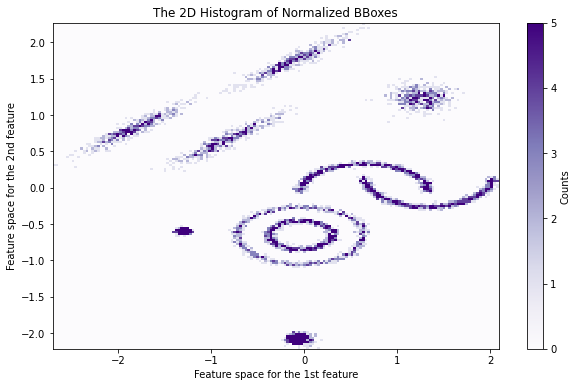

In [30]:
fig2 = plt.figure(figsize=(10, 6))
plt.hist2d(toy_data[ :, 0 ], toy_data[ :, 1 ], bins=160 , cmap = 'Purples' , vmax = 5 )
plt.title("The 2D Histogram of Normalized BBoxes")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')

In [31]:
class DBSCAN:
    def __init__ ( self , min_points = 5 , radius = 0.1 , affinity = 'euclidean' , a_mat = None):
        self.min_points = min_points
        self.radius = radius
        self.affinity = affinity
        self.clusters = {}
        self.visited_samples = []
        self.neighbors = {}
        self.a_mat = a_mat
        self.affinity_mat = a_mat
        self.cluster_count = 0
        self.predicted_labels = 0

    def cal_affinity( self , data ):
        n = data.shape[ 0 ]
        self.affinity_mat = np.zeros(( n , n ))
        for first_data in range( n ):
            for second_data in range( first_data , n ):
                self.affinity_mat[ first_data , second_data ] = self.affinity_dist( data[ first_data , : ] , data[ second_data , : ] )
                self.affinity_mat[ second_data , first_data ] = self.affinity_mat[ first_data , second_data ]

    def affinity_dist( self , x , y ):
        if self.affinity == 'euclidean' : 
            return LA.norm( x - y )
        elif self.affinity == 'manhattan' : 
            return LA.norm( x - y , ord = 1 )

    def get_neighbors( self , target ):
        neighbors = []
        for sample in range( self.data.shape[ 0 ] ):
            if self.affinity_mat[ target , sample ] < self.radius and sample != target:
                neighbors.append( sample )
        return np.array( neighbors )

    def expand_cluster( self , sample , neighbors ):
        cluster = np.array([ sample ])
        for sample_neighbor in neighbors:
            if sample_neighbor not in self.visited_samples:
                self.visited_samples.append( sample_neighbor )
                self.neighbors[ sample_neighbor ] = self.get_neighbors( sample_neighbor )
                if self.neighbors[ sample_neighbor ].shape[ 0 ] >= self.min_points:
                    new_cluster = self.expand_cluster(sample_neighbor , self.neighbors[ sample_neighbor ])
                    cluster = np.append( cluster , new_cluster )
                else:
                    cluster = np.append( cluster , sample_neighbor )
        return cluster

    def assign_labels( self ):
        temp = -1*np.ones( self.data.shape[ 0 ] )
        for target_cluster in self.clusters.keys():
            for sample in self.clusters[ target_cluster ]:
                temp[ sample ] = target_cluster
        return temp

    def run( self , data ):
        self.data = data
        n = self.data.shape[ 0 ]
        if np.all(self.a_mat) == None : # As we have massive time complexity for calculating distance matrix, it gets distance matrix that was calculated before as an arg.
            self.cal_affinity( self.data )
        for sample in range( n ):
            # calculated how much of progress proceeds.
            sys.stdout.flush()
            sys.stdout.write('\r')
            percent = (sample*100)/(n-1)
            percent_5  = int(percent//5)
            sys.stdout.write("[%-20s] %.3f%%" % ('='*percent_5, percent))

            if sample in self.visited_samples: # if new sample is visted, go to next sample.
                continue
            self.neighbors[ sample ] = self.get_neighbors( sample )
            if len( self.neighbors[ sample ] ) >= self.min_points:
                self.visited_samples.append( sample )
                generated_cluster = self.expand_cluster( sample , self.neighbors[ sample ] )
                self.clusters[ self.cluster_count ] = generated_cluster
                self.cluster_count += 1
        self.predicted_labels = self.assign_labels()

In [32]:
def tune_DBSCAN( range_points , range_radius , data ):
    silhouette_avg = np.zeros(( len( range_points ) , len( range_radius ) ))
    for i in range( len( range_radius ) ):
        for j in range( len( range_points ) ):
            if i == 0 and j == 0 :
                db = DBSCAN( min_points = range_points[ j ] , radius = range_radius[ i ]  )
                distances = db.affinity_mat
            else:
                db = DBSCAN( min_points = range_points[ j ] , radius = range_radius[ i ] , a_mat = distances )
            db.run( data )
            silhouette_avg[ j , i ] = np.exp(5*sklearn.metrics.silhouette_score( data , db.predicted_labels ))
    max = np.unravel_index( np.argmax( silhouette_avg ) , silhouette_avg.shape )
    max_score = ( range_points[ max[ 1 ] ] , range_radius[ max[ 0 ] ] )
    return silhouette_avg , max_score

## Testing algorithm for BBoxes.

In [33]:
affinity = db.affinity_mat

NameError: name 'db' is not defined

In [34]:
sys.setrecursionlimit(20000)
db = DBSCAN( min_points = 35 , radius = 0.0351 , a_mat=affinity )
db.run( norm_bboxes )

NameError: name 'affinity' is not defined

In [35]:
df = pd.DataFrame( db.predicted_labels )
df.to_csv('Toy_Shuffled_assigned_labels.csv')
!cp Toy_Shuffled_assigned_labels.csv "drive/My Drive/IS/Final/"
df_1 = pd.DataFrame( toy_data )
df_1.to_csv('Toy_shuffled_DBSCAN.csv')
!cp Toy_shuffled_DBSCAN.csv "drive/My Drive/IS/Final/"

NameError: name 'db' is not defined

NameError: name 'db' is not defined

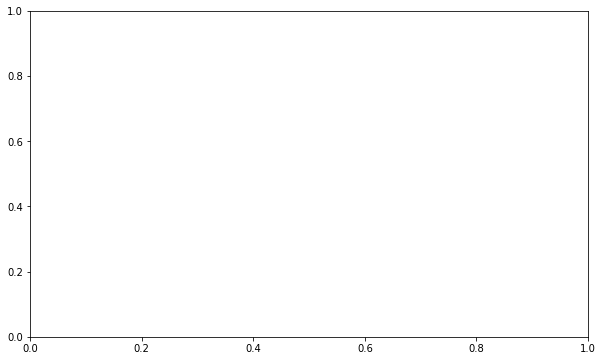

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = cm.Purples(db.predicted_labels.astype(float) / np.unique(db.predicted_labels).shape[0] + 0.5 )
ax.scatter(norm_bboxes[:, 0], norm_bboxes[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors)
centers = [np.mean(norm_bboxes[db.predicted_labels == i], axis = 0) for i in range(np.unique(db.predicted_labels).shape[0])]
for i, c in enumerate(centers): ax.scatter(c[0], c[1],  marker='o', c="white", alpha = 1, s = 200, edgecolor='k')
for i, c in enumerate(centers): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s =50, edgecolor='k')
ax.set_title("The visualization of the clustered data(from scratch)")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
plt.show()

# Testing algorithm for Toy-data

In [ ]:
points = np.arange(2,12)
radius = 0.01*np.arange(2,10)
silhoutte_avg , max = tune_DBSCAN( points , radius , toy_data[0:1000 , :] )

[                    ] 0.000%0%

In [ ]:
import seaborn as sn
def show_Tune_matrix(cm):
    a = np.arange(2,12)
    b = 0.01*np.arange(2,10)
    df_cm = pd.DataFrame(cm, index = [i for i in a],columns = [i for i in b])
    plt.figure(figsize = (10,10))
    plt.xlabel("Minimum points ")
    plt.ylabel("Radius")
    plt.title("Silhouette Average in 1000 samples of Toy-dataset")
    sn.heatmap(df_cm, annot=True,cmap = "Purples",fmt ='2g')

In [ ]:
show_Tune_matrix( silhoutte_avg )

Choosing best based on best pair in silhouette average score.

In [ ]:
db = DBSCAN( min_points = 4 , radius = 0.09 , a_mat=distance_mat_Toydata )
db.run( toy_data )

In [50]:
distance_mat_Toydata = db.affinity_mat

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


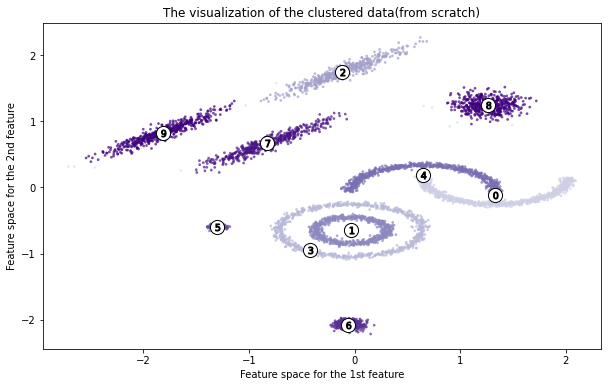

In [71]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = cm.Purples(db.predicted_labels.astype(float) / np.unique(db.predicted_labels).shape[0] + 0.3 )
ax.scatter(toy_data[:, 0], toy_data[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors)
centers = [np.mean(toy_data[db.predicted_labels == i],axis =0) for i in range(np.unique(db.predicted_labels).shape[0])]
for i in range(np.unique(db.predicted_labels).shape[0]):
    if db.predicted_labels[ i ] == 1:
        centers[ 3 ] = np.array(toy_data[i])
        break
for i, c in enumerate(centers): ax.scatter(c[0], c[1],  marker='o', c="white", alpha = 1, s = 200, edgecolor='k')
for i, c in enumerate(centers): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s =50, edgecolor='k')
ax.set_title("The visualization of the clustered data(from scratch)")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
plt.show()


In [ ]:
algorithms = ['DBSCAN']
print(f"DBSCAN metrics: separation index: {sep_ind}, fdi: {fda_ind}\n")
#barchart_comparison(algorithms, sep_ind, fda_ind)